### Notebook to study the conversion of wake function to wake potential
And viceversa

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import iddefix
import numpy as np
from scipy.constants import c as c_light

## Using resonator table from `004`

In [3]:
# Importing wake potential data
data_wake_potential = np.loadtxt('examples/data/004_SPS_model_transitions_q26.txt', comments='#', delimiter='\t')

# Extracting data
data_wake_time = data_wake_potential[:,0]*1e-9 # [s]
data_wake_dipolar = data_wake_potential[:,2]   # [V/C]
sigma = 1e-10 # [s]

# Read old results for DE model
DE_model = iddefix.EvolutionaryAlgorithm(data_wake_time,
                                         data_wake_dipolar*c_light, # remove normalization
                                         N_resonators=12,
                                         parameterBounds=None,
                                         plane='transverse',
                                         fitFunction='wake potential',
                                         sigma=sigma)

from io import StringIO
data_str = StringIO('''
----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.22e+00        |      75.53       |    1.005e+09     
    2     |        8.70e+00        |      161.35      |    1.176e+09     
    3     |        1.14e+00        |      15.39       |    1.269e+09     
    4     |        1.05e+00        |      36.20       |    1.656e+09     
    5     |        1.70e+00        |      183.33      |    2.075e+09     
    6     |        1.52e+00        |      173.31      |    2.194e+09     
    7     |        1.67e+00        |      52.78       |    2.248e+09     
    8     |        1.84e+00        |      44.76       |    2.431e+09     
    9     |        1.86e+00        |       4.82       |    2.671e+09     
    10    |        1.88e+00        |      177.15      |    2.908e+09     
    11    |        1.86e+00        |      41.74       |    3.181e+09     
----------------------------------------------------------------------
''')

DE_model.minimizationParameters = np.loadtxt(
        data_str, skiprows=4, max_rows=9,usecols=(1, 2, 3),
        delimiter='|', dtype=float,).flatten()

Computing the wake function with `Neffint` and comparing to the analytical from the DE

In [4]:
# Getting the wake function with neffint - this can take a while!
import neffint

time = np.linspace(1e-11, 50e-9, 1000)
f_fd = np.linspace(0, 5e9, 1000)
Z_fd = DE_model.get_impedance(frequency_data=f_fd, wakelength=None)
adaptative = True #gives same results, just slower

t, W = iddefix.compute_ineffint(f_fd, Z_fd, #for transverse
                                 times=time,
                                 plane='transverse',
                                 adaptative=adaptative)

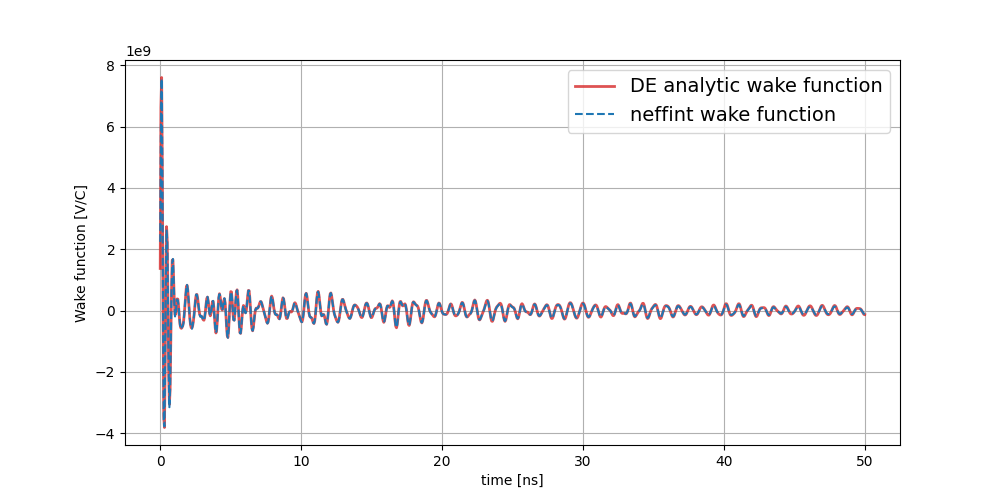

In [5]:
# Compare wake functions
W_de = DE_model.get_wake(time)
fig, ax0 = plt.subplots(1, 1, figsize=(10,5))

ax0.plot(time*1e9, W_de,
         lw = 2, c='tab:red', linestyle='-', alpha=0.8, label='DE analytic wake function')
ax0.plot(time*1e9, W, 
         lw = 1.5, c='tab:blue', linestyle='--', label='neffint wake function')

ax0.set_xlabel('time [ns]')
ax0.set_ylabel('Wake function [V/C]')
ax0.legend(loc='best', fontsize=14)
ax0.grid()

Calculate the wake potential from the DE model and from a convolution
* Compare to original wake potential from CST

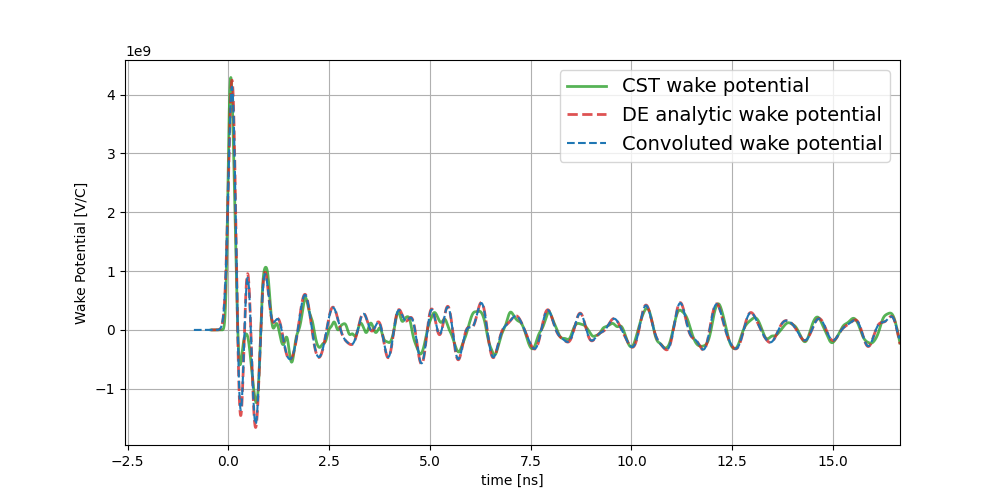

In [6]:
# Let's convolute the wake function with the beam profile
sigma = 0.2e-10
WP_de = DE_model.get_wake_potential(data_wake_time, sigma=sigma)
time_convoluted, WP_convoluted = iddefix.compute_convolution(data_wake_time, WP_de, 
                                                             sigma=sigma, kernel='numpy')

# And compare it to the original wake potential data
fig, ax0 = plt.subplots(1, 1, figsize=(10,5))

ax0.plot(data_wake_time*1e9, data_wake_dipolar*c_light,
         lw = 2, c='tab:green', linestyle='-', alpha=0.8, label='CST wake potential')
ax0.plot(data_wake_time*1e9, WP_de,
         lw = 2, c='tab:red', linestyle='--', alpha=0.8, label='DE analytic wake potential')
ax0.plot(time_convoluted*1e9, WP_convoluted, 
         lw = 1.5, c='tab:blue', linestyle='--', label='Convoluted wake potential')

ax0.set_xlabel('time [ns]')
ax0.set_ylabel('Wake Potential [V/C]')
ax0.set_xlim(xmax=data_wake_time[-1]*1e9)
ax0.legend(loc='best', fontsize=14)
ax0.grid()

Benchmark the convolution method by comparing it with the wake function:
* Wake potential should tend to wake function with a sufficiently small bunch length

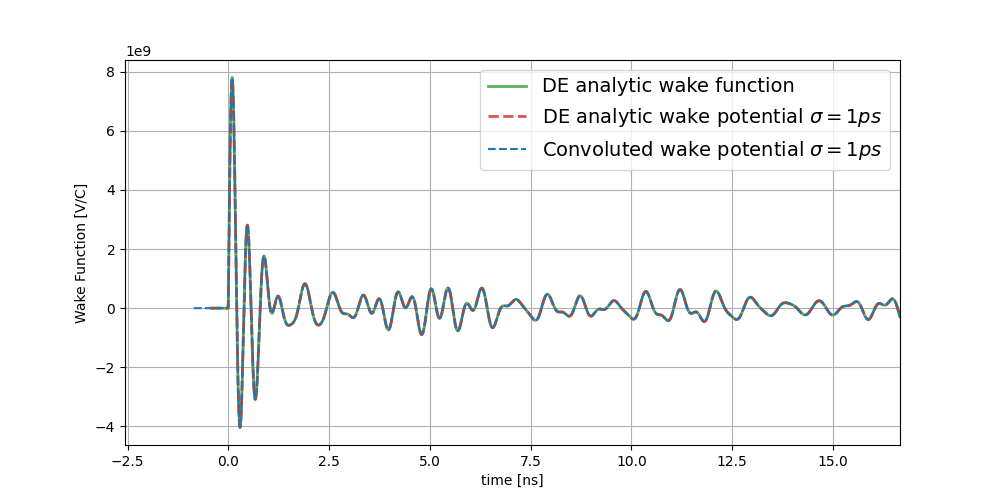

In [7]:
# Let's convolute the wake function with the beam profile
sigma = 1e-12 # [s]
W_de= DE_model.get_wake(data_wake_time)
WP_de = DE_model.get_wake_potential(data_wake_time, sigma=sigma)
time_convoluted, WP_convoluted = iddefix.compute_convolution(data_wake_time, WP_de, 
                                                             sigma=sigma, kernel='numpy')

# And compare it to the original wake potential data
fig, ax0 = plt.subplots(1, 1, figsize=(10,5))

ax0.plot(data_wake_time*1e9, W_de,
         lw = 2, c='tab:green', linestyle='-', alpha=0.8, label='DE analytic wake function')
ax0.plot(data_wake_time*1e9, WP_de,
         lw = 2, c='tab:red', linestyle='--', alpha=0.8, label=r'DE analytic wake potential $\sigma=1 ps$')
ax0.plot(time_convoluted*1e9, WP_convoluted, 
         lw = 1.5, c='tab:blue', linestyle='--', label='Convoluted wake potential $\sigma=1 ps$')

ax0.set_xlabel('time [ns]')
ax0.set_ylabel('Wake Function [V/C]')
ax0.set_xlim(xmax=data_wake_time[-1]*1e9)
ax0.legend(loc='best', fontsize=14)
ax0.grid()

## Using FCC beam pipe from IW2D (E. Macchia)

(-1097.0055642452735, 1097.0055642452735)

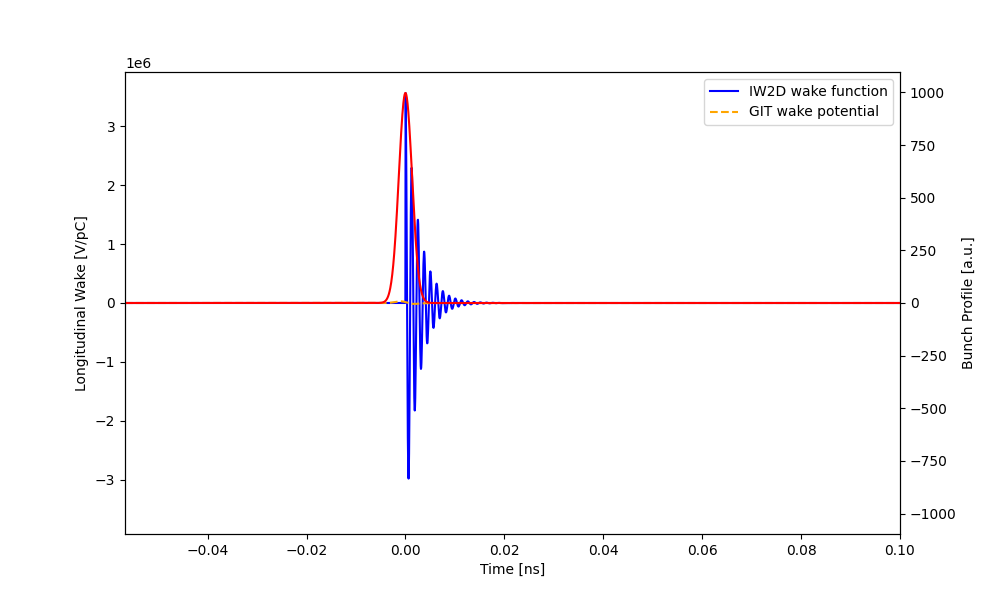

In [8]:
data = np.loadtxt("examples/data/006_beampipe_wake_iw2d.txt")
t_iw2d = data[:, 0] # [s] 
Wlong_iw2d = data[:,1]/1e12 # [V/pC]

data = np.loadtxt("examples/data/006_wakepot_long_GIT.dat")
pos = data[:, 0] # [m] 
t_GIT = pos/c_light # [s]
Wlong_GIT = -data[:,1]/1e12 # [V/pC]

# Plot 
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(t_iw2d*1e9, Wlong_iw2d, label='IW2D wake function', color='blue')
ax.plot(t_GIT*1e9, Wlong_GIT, label='GIT wake potential', color='orange', ls='--')
ax.set_xlabel('Time [ns]')
ax.set_ylabel('Longitudinal Wake [V/pC]')
ax.set_ylim(-1.1 * np.max(Wlong_iw2d), 1.1 * np.max(Wlong_iw2d))
ax.set_xlim(t_iw2d[0]*1e9, 0.1)
ax.legend()

axx = ax.twinx()
# Generate the gaussian bunch profile
bunch_len_m = 0.4e-3  # [m] - 0.4 mm bunch length
bunch_len = bunch_len_m / c_light # [s]
t_bunch = t_iw2d #np.linspace(-10*bunch_len, 100*bunch_len, 10000)
bunch = iddefix.gaussian_bunch(t_bunch, bunch_len)
axx.plot(t_bunch*1e9, bunch, label='Gaussian Bunch', color='red')
axx.set_ylabel('Bunch Profile [a.u.]')
axx.set_ylim(-1.1 * np.max(bunch), 1.1 * np.max(bunch))



(-1097.0055642452735, 1097.0055642452735)

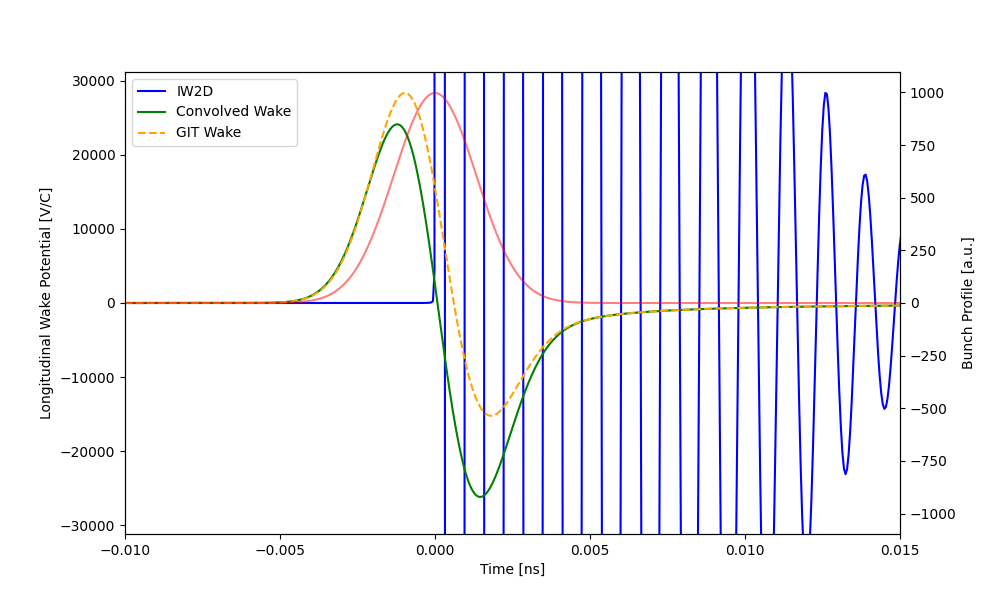

In [9]:
t_convolved, Wlong_convolved = iddefix.compute_convolution(t_iw2d, Wlong_iw2d,
                                                            sigma=bunch_len, kernel='numpy')

# Plot 
fig, ax = plt.subplots(1, figsize=(10, 6), dpi=100)
ax.plot(t_iw2d*1e9, Wlong_iw2d, label='IW2D', color='blue')
ax.plot(t_convolved*1e9, Wlong_convolved, label='Convolved Wake', color='green')
ax.plot(t_GIT*1e9, Wlong_GIT, label='GIT Wake', color='orange', ls='--')
ax.set_xlabel('Time [ns]')
ax.set_ylabel('Longitudinal Wake Potential [V/C]')
ax.set_ylim(-1.1 * np.max(Wlong_GIT), 1.1 * np.max(Wlong_GIT))
ax.set_xlim(-0.01, +0.015) 
ax.legend()

axx = ax.twinx()
axx.plot(t_bunch*1e9, bunch, label='Gaussian Bunch', color='red', alpha=0.5)
axx.set_ylabel('Bunch Profile [a.u.]')
axx.set_ylim(-1.1 * np.max(bunch), 1.1 * np.max(bunch))
#plt.yscale('symlog')


Benchmarking the convolution method with a sufficient small bunch length 
* We should retrieve the original wake function

(-36430.0836349435, 36430.0836349435)

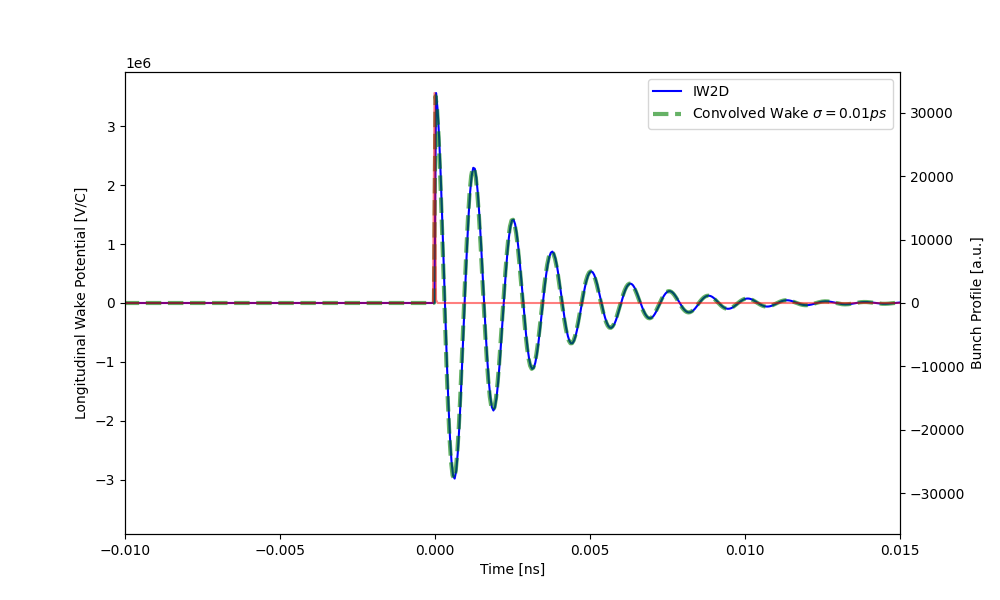

In [10]:
min_sigma = 1e-14  # [s] - very small sigma to retrieve the original wake function
t_convolved, Wlong_convolved = iddefix.compute_convolution(t_iw2d, Wlong_iw2d,
                                                            sigma=min_sigma, kernel='numpy')

# Plot 
fig, ax = plt.subplots(1, figsize=(10, 6), dpi=100)
ax.plot(t_iw2d*1e9, Wlong_iw2d, label='IW2D', color='blue')
ax.plot(t_convolved*1e9, Wlong_convolved, label=r'Convolved Wake $\sigma=0.01 ps$', lw=3, ls='--', alpha=0.6, color='green')
#ax.plot(t_GIT*1e9, Wlong_GIT, label='GIT Wake', color='orange', ls='--')
ax.set_xlabel('Time [ns]')
ax.set_ylabel('Longitudinal Wake Potential [V/C]')
ax.set_ylim(-1.1 * np.max(Wlong_iw2d), 1.1 * np.max(Wlong_iw2d))
ax.set_xlim(-0.01, +0.015) 
ax.legend()

axx = ax.twinx()
bunch = iddefix.gaussian_bunch(t_bunch, min_sigma)
axx.plot(t_bunch*1e9, bunch, label='Gaussian Bunch', color='red', alpha=0.5)
axx.set_ylabel('Bunch Profile [a.u.]')
axx.set_ylim(-1.1 * np.max(bunch), 1.1 * np.max(bunch))
#plt.yscale('symlog')

In [11]:
# TODO: Getting the wake function with neffint - this can take a while!
# import neffint

# time = np.linspace(1e-13, 0.02e-9, 1000)
# fmax = 300e9
# f_GIT, Zlong_GIT = iddefix.compute_fft(t_GIT, Wlong_GIT, fmax=fmax, samples=1001)
# adaptative = True #gives same results, just slower

# t, W = iddefix.compute_ineffint(f_GIT, Zlong_GIT, #for transverse
#                                  times=time,
#                                  plane='longitudinal',
#                                  adaptative=adaptative)

In [12]:
# # Plot 
# fig, ax = plt.subplots(1, figsize=(10, 6), dpi=100)
# #ax.plot(t_iw2d*1e9, Wlong_iw2d, label='IW2D', color='blue')
# #ax.plot(t_convolved*1e9, Wlong_convolved, label=r'Convolved Wake $\sigma=0.01 ps$', lw=3, ls='--', alpha=0.6, color='green')
# ax.plot(t*1e9, W, label='Deconvolved GIT Wake', color='orange', ls='--', lw=3, alpha=0.6,)
# ax.set_xlabel('Time [ns]')
# ax.set_ylabel('Longitudinal Wake Potential [V/C]')
# #ax.set_ylim(-1.1 * np.max(Wlong_iw2d), 1.1 * np.max(Wlong_iw2d))
# #ax.set_xlim(-0.01, +0.015) 
# ax.legend()

Compare the resulting frequency domain signals:
* Impact of using a wake function or wake potential on impedance frequency content 

In [13]:
# Compute the FFT
import iddefix
fmax=300e9
f_iw2d, Zlong_iw2d = iddefix.compute_fft(t_iw2d, Wlong_iw2d, fmax=fmax, samples=10001)
f_GIT, Zlong_GIT = iddefix.compute_fft(t_GIT, Wlong_GIT, fmax=fmax, samples=10001)
f_convolved, Zlong_convolved = iddefix.compute_fft(t_convolved, Wlong_convolved, fmax=fmax, samples=10001)
f_bunch, Z_bunch = iddefix.compute_fft(t_bunch, bunch, fmax=fmax, samples=10001)

Text(0, 0.5, 'Bunch Spectrum [a.u.]')

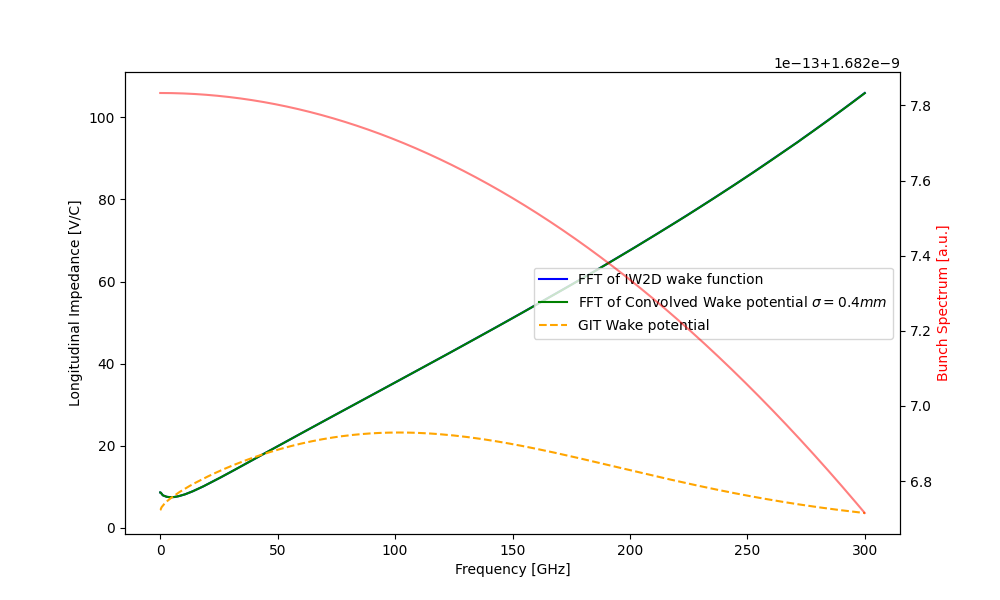

In [14]:
# Plot 
fig, ax = plt.subplots(1, figsize=(10, 6), dpi=100)
ax.plot(f_iw2d/1e9, np.abs(Zlong_iw2d), label='FFT of IW2D wake function', color='blue')
ax.plot(f_convolved/1e9, np.abs(Zlong_convolved), label='FFT of Convolved Wake potential $\sigma=0.4 mm$', color='green')
ax.plot(f_GIT/1e9, np.abs(Zlong_GIT), label='GIT Wake potential', color='orange', ls='--')
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Longitudinal Impedance [V/C]')
ax.legend(loc=5)

axx = ax.twinx()
axx.plot(f_bunch/1e9, np.abs(Z_bunch/c_light), label='Gaussian Bunch', color='red', alpha=0.5)
axx.set_ylabel('Bunch Spectrum [a.u.]', color='r')